In [32]:
%pip install seaborn
# To avoid the deprecation warning
%pip install pandas
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import numpy as np
from scipy import stats

In [2]:
# Import Datasets
launches = pd.read_csv('Launches.csv')
configs = pd.read_csv('Configs.csv')
families = pd.read_csv('Families.csv')
companies = pd.read_csv('Companies.csv')
locations = pd.read_csv('Locations.csv')
missions = pd.read_csv('Missions.csv')

As our dataset is split up between 6 csv files, the dataframe must combine the data from them. For that, we will use joins and, for them to work, the data types must be correctly aligned.

In [3]:
configs['Family Id'] = configs['Family Id'].astype(int)

rockets = pd.merge(configs, families, how = 'inner', on = 'Family Id')

launch_data = pd.merge(launches, locations, how = 'inner', left_on = 'Location', right_on = 'Orig_Addr')
launch_data = pd.merge(launch_data, rockets, how = 'inner', right_on = 'Config', left_on = 'Rocket Name')
launch_data = pd.merge(launch_data, companies, how = 'inner', left_on = 'Rocket Organisation', right_on = 'Company Name')
launch_data = pd.merge(launch_data, missions, how = 'inner', on = 'Launch Id')

Let's now consider the dataset info and all feature present after merging all csvs.

In [4]:
launch_data.describe()
launch_data.head()
launch_data.columns

Index(['Launch Id', 'Launch Time', 'Launch Status', 'Launch Suborbital',
       'Rocket Name', 'Rocket Organisation', 'Rocket Price',
       'Rocket Payload to LEO', 'Location', 'Launch Year', 'Launch Year Mon',
       'USD/kg to LEO', '2021 Mult', 'USD/kg to LEO CPI Adjusted',
       'Rocket Price CPI Adjusted', 'Dum', 'Orig_Addr', 'Country',
       'Country_Code', 'Lat', 'Lon', 'Operator', 'Launch Site',
       'Launch Site Lat', 'Launch Site Lon', 'Comb Launch Site',
       'Comb Launch Site Lat', 'Comb Launch Site Lon', 'Operator Lat',
       'Operator Lon', 'Family Id', 'No_x', 'Config', 'Status', 'Price',
       'Liftoff Thrust', 'Payload to LEO', 'Payload to GTO', 'Stages',
       'Strap-ons', 'Rocket Height', 'Fairing Diameter', 'Fairing Height',
       'Family', 'Missions', 'Successes', 'Partial Failures', 'Failures',
       'Success Streak', 'Success Rate', 'Company Name', 'Company Country',
       'Ownership', 'No_y', 'Payloads', 'Mass'],
      dtype='object')

Columns such as the launch id can be ignored, as they are not useful for our analysis. Duplicate rows should also be removed, as well as rows where there is lack of information.

In [5]:
launch_data = launch_data.drop_duplicates()
launch_data = launch_data.dropna()
launch_data = launch_data.drop(["Launch Id"], axis="columns")

# TODO - Left a List with conversions necessary to analyze outliers

Now, we must analyze the features in use and their types, in order to identify outliers. Firstly, all objects must be either trashed or transformed into data that can be easily processed.
After that, we must analyse the numerical feature and remove any outliers.

In [6]:
launch_data.dtypes

Launch Time                    object
Launch Status                  object
Launch Suborbital              object
Rocket Name                    object
Rocket Organisation            object
Rocket Price                  float64
Rocket Payload to LEO         float64
Location                       object
Launch Year                     int64
Launch Year Mon                object
USD/kg to LEO                 float64
2021 Mult                     float64
USD/kg to LEO CPI Adjusted    float64
Rocket Price CPI Adjusted     float64
Dum                             int64
Orig_Addr                      object
Country                        object
Country_Code                   object
Lat                           float64
Lon                           float64
Operator                       object
Launch Site                    object
Launch Site Lat               float64
Launch Site Lon               float64
Comb Launch Site               object
Comb Launch Site Lat          float64
Comb Launch 

As the following plot shows, we have a very imbalanced dataset when considering this specific fields. In order to lower its impact, there are a few approaches that can be taken into consiration. In this instance, we decided to go for under-sampling.

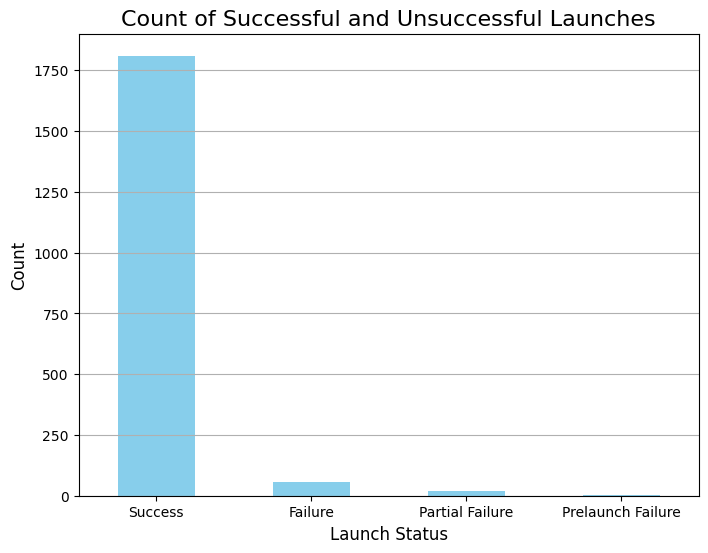

In [7]:
# Count the number of successful and unsuccessful launches
status_counts = launch_data['Launch Status'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [8]:
launch_data['Launch Status'].value_counts()

Launch Status
Success              1810
Failure                56
Partial Failure        20
Prelaunch Failure       1
Name: count, dtype: int64

In [9]:

df_majority = launch_data[launch_data['Launch Status'] == 'Success']
df_minority = launch_data[launch_data['Launch Status'] != 'Success']

sample_size = int(len(df_majority)/16)
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=sample_size,     # match number in minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
balanced_status = df_balanced['Launch Status'].value_counts()

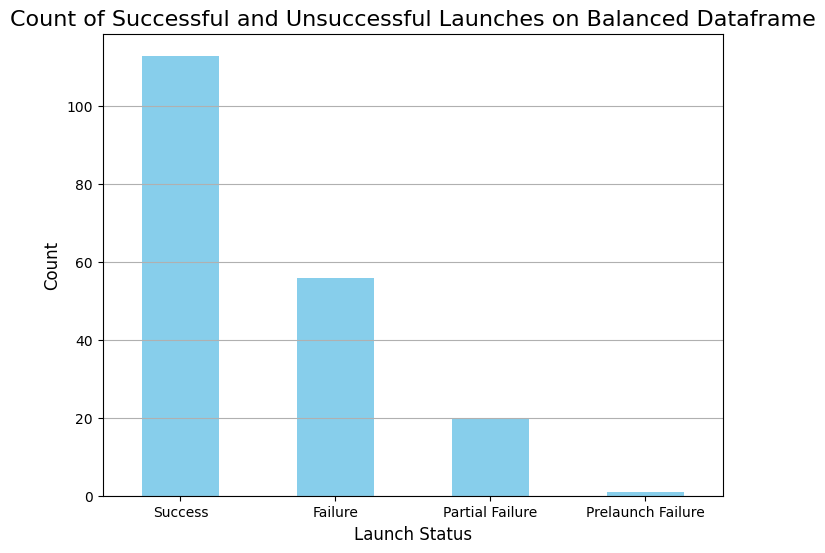

In [10]:
# Plot the histogram
plt.figure(figsize=(8, 6))
balanced_status.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches on Balanced Dataframe', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## Following the first question: does the price influence the success of a Launch?

### Let's follow a Hypothesis Testing.

### Hypothesis
1) Null Hypothesis (Ho): Price has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): Price influences positively the success of a launch. (Is there a correlation?)

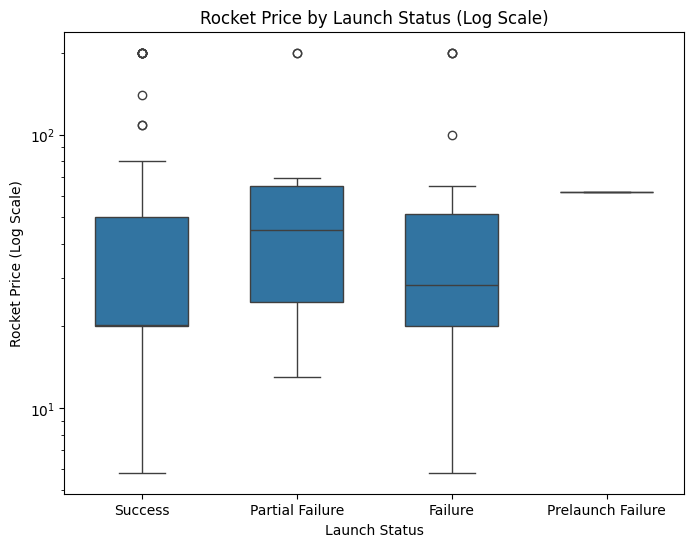

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Launch Status', y='Rocket Price', data=df_balanced, width=0.6)
plt.yscale('log') 
plt.title('Rocket Price by Launch Status (Log Scale)')
plt.xlabel('Launch Status')
plt.ylabel('Rocket Price (Log Scale)')
plt.show()

The pairplot visualization suggests that rocket price is not a decisive factor in determining launch success, as failures happen across all price ranges.

In [34]:
# Assuming df_balanced is your dataframe
rocket_prices = df_balanced['Rocket Price']
launch_success = (df_balanced['Launch Status'] == 'Success').astype(int)

# Calculate point-biserial correlation
correlation, p_value = stats.pointbiserialr(launch_success, rocket_prices)

print(f"Correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket price and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.")

Correlation coefficient: -0.0107
P-value: 0.8834
Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.


To examine the relationship between rocket price and launch success, we conducted a point-biserial correlation test. This test is appropriate for analyzing the association between a continuous variable (rocket price) and a dichotomous variable (launch success: 0 or 1). The results show:

- Correlation coefficient: -0.0107
- P-value: 0.8834

With a p-value of 0.8834, which is much larger than the conventional significance level of 0.05, we fail to reject the null hypothesis. This suggests that there is no statistically significant relationship between rocket price and launch success.

The correlation coefficient of -0.0107 indicates a very weak negative relationship between price and success. However, given the high p-value, this relationship is not statistically significant and is likely due to random chance rather than a true association in the population.

In conclusion, based on this point-biserial correlation test, we cannot conclude that rocket price has a meaningful influence on launch success. The data suggests that other factors, beyond price, are likely more important in determining the outcome of a rocket launch. The near-zero correlation and high p-value provide strong evidence that there is no significant linear relationship between rocket price and the probability of a successful launch in our dataset.

## Following the second question: Is there any corporation more likely to succeed in a launch??

In [29]:
success_rate = (
    df_balanced.groupby('Rocket Organisation')['Success_Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate', 'Total Launches'], ascending=[False, False])

success_rate.head()

,Total Launches,Successful Launches,Success Rate
Rocket Organisation,,,
SpaceX,14,11,0.785714
RVSN USSR,62,44,0.709677
Arianespace,18,12,0.666667
CASC,18,12,0.666667
International Launch Services,11,6,0.545455


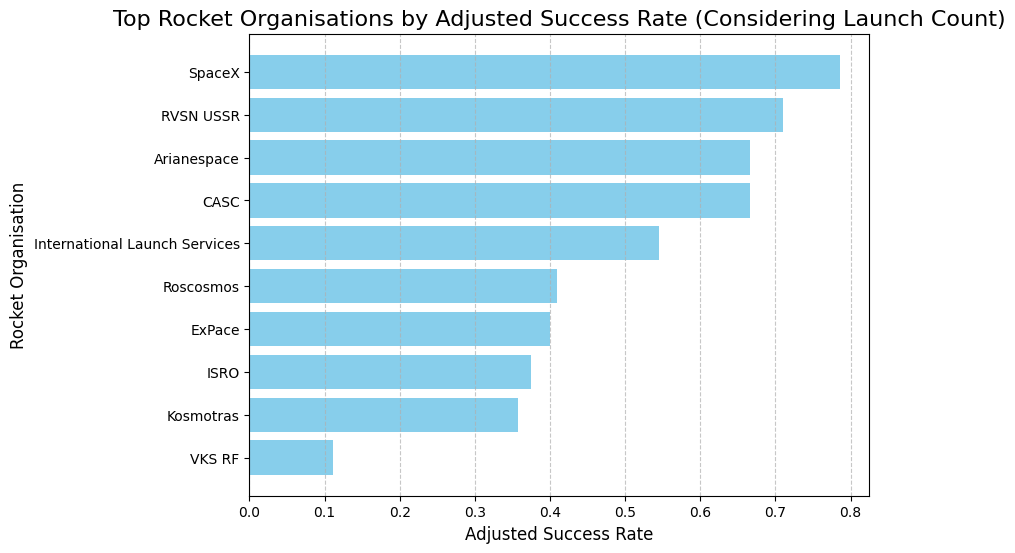

In [30]:
plt.figure(figsize=(8, 6))
plt.barh(success_rate.index, success_rate['Success Rate'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top Rocket Organisations by Adjusted Success Rate (Considering Launch Count)', fontsize=16)
plt.xlabel('Adjusted Success Rate', fontsize=12)
plt.ylabel('Rocket Organisation', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Last but not least: is there any country more likely to succeed in a launch?

In [139]:
success_rate = (
    df_balanced.groupby('Country')['Success_Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate', 'Total Launches'], ascending=[False, False])

success_rate.head()

,Total Launches,Successful Launches,Success Rate
Country,,,
China,35,26,0.742857
United States,10,7,0.700000
Russia,57,37,0.649123
French Guiana,16,10,0.625000
Kazakhstan,66,32,0.484848
